# Creating custom Metrics 

In [ ]:
import mlflow
from mlflow_for_ml_dev.src.utils.folder_operations import get_project_root
from mlflow.metrics import EvaluationMetric
from mlflow.metrics import MetricValue

import pandas as pd
from typing import Dict
from typing import Union
import random

# set mlflow tracking uri
mlflow.set_tracking_uri(uri=(get_project_root() / 'mlruns').as_uri())

In [ ]:
# create the experiment
experiment_name = "custom-metrics"
try: 
    _ = mlflow.create_experiment(name=experiment_name)
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(name=experiment_name)
# set experiment
experiment = mlflow.set_experiment(experiment_name)

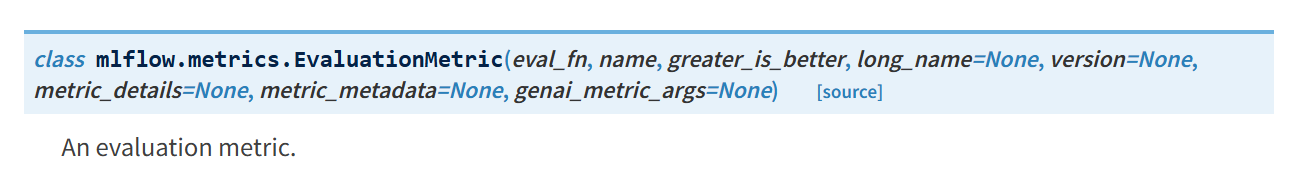

In [ ]:
# Defining the custom metric (eval_fn)
def custom_accuracy(predictions:pd.Series, targets:pd.Series, metrics:Dict[str, MetricValue])->Union[float, MetricValue]:
    """
    Custom accuracy metric

    :param predictions: The predictions of the model
    :param targets: The target values
    :param metrics: The metrics dictionary
    :param kwargs: Additional arguments
    :return: MetricValue
    """
    custom_accuracy = (predictions == targets).sum() / len(targets)
    return custom_accuracy



In [ ]:
test_df = pd.DataFrame({
    "predictions": [random.randint(0, 1) for _ in range(100)],
    "targets": [random.randint(0, 1) for _ in range(100)]
})
test_df.head()

use the custom metric

In [ ]:
custom_accuracy(test_df["predictions"], test_df["targets"], {})

In [ ]:
# defining the custom evaluation metric
my_accuracy = EvaluationMetric(
    eval_fn=custom_accuracy,
    name="custom_accuracy",
    greater_is_better=True,
    metric_details="Custom accuracy metric",
    metric_metadata={"version": "0.0.1", "type": "custom"},
    version="v0.0.1"
)

## Using Custom Metrics

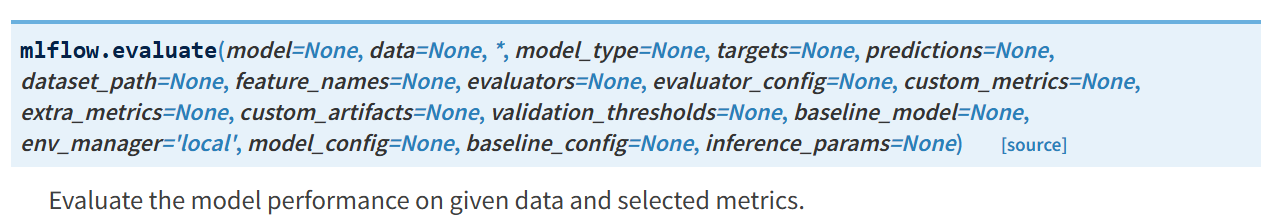

This function evaluates a PyFunc model or custom callable on the specified dataset using specified evaluators, and logs resulting metrics & artifacts to MLflow tracking server. Users can also skip setting model and put the model outputs in data directly for evaluation. For detailed information, please read the Model Evaluation documentation.

In [ ]:
results = mlflow.evaluate(
    data=test_df,
    model_type="classifier",
    targets="targets",
    predictions="predictions",
    extra_metrics=[my_accuracy],
)

In [ ]:
results.metrics

# Calculate metrics from other metrics

In [ ]:
def good_enough(predictions:pd.Series, targets:pd.Series, metrics:Dict[str, MetricValue])->Union[float, MetricValue]:
    """
    Custom accuracy metric

    :param predictions: The predictions of the model
    :param targets: The target values
    :param metrics: The metrics dictionary
    :param kwargs: Additional arguments
    :return: MetricValue
    """
    custom_accuracy = metrics['custom_accuracy/v0.0.1'].aggregate_results.get("custom_accuracy")
    if custom_accuracy >= 0.8:
        return 1
    else:
        return 0
    
good_enough_metric = EvaluationMetric(
    eval_fn=good_enough,
    name="good_enough",
    greater_is_better=True,
    metric_details="Good enough metric",
    metric_metadata={"version": "0.0.1", "type": "custom"},
    version="v0.0.1"
)

In [ ]:
results = mlflow.evaluate(
    data=test_df,
    model_type="classifier",
    targets="targets",
    predictions="predictions",
    extra_metrics=[my_accuracy, good_enough_metric],
)

In [ ]:
results.metrics 

# Creating custom metrics using make_metric method

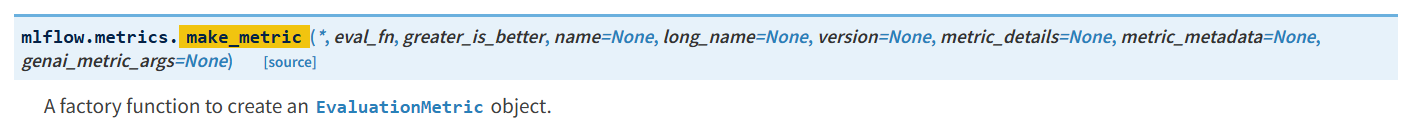

In [ ]:
import random

def random_metric(predictions:pd.Series, targets:pd.Series, metrics:Dict[str, MetricValue])->Union[float, MetricValue]:
    """
    Random metric.

    :param predictions: The predictions of the model
    :param targets: The target values
    :param metrics: The metrics dictionary
    :param kwargs: Additional arguments
    :return: MetricValue
    """

    return random.random()

In [ ]:
my_random_metric = mlflow.metrics.make_metric(
    eval_fn=random_metric,
    name="random_metric",
    metric_details="Random metric",
    greater_is_better=True,
    metric_metadata={"version": "0.0.1", "type": "custom"},
    version="v0.0.1"
)

In [ ]:
results = mlflow.evaluate(
    data=test_df,
    model_type="classifier",
    targets="targets",
    predictions="predictions",
    extra_metrics=[my_accuracy, good_enough_metric, my_random_metric]
)

In [ ]:
results.metrics